In [1]:
#Importing the necessary libararies for the analysis
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from sklearn.svm import SVR

## Loading the data into the pandas dataframe

In [2]:
#reading the data using the pandas module
df=pd.read_csv("eth_15min.csv")
df=df.rename(columns={'Unnamed: 0': 'timestamp'})
df=df.set_index("timestamp")#setting the timestamp as index

## visualization of the final target 

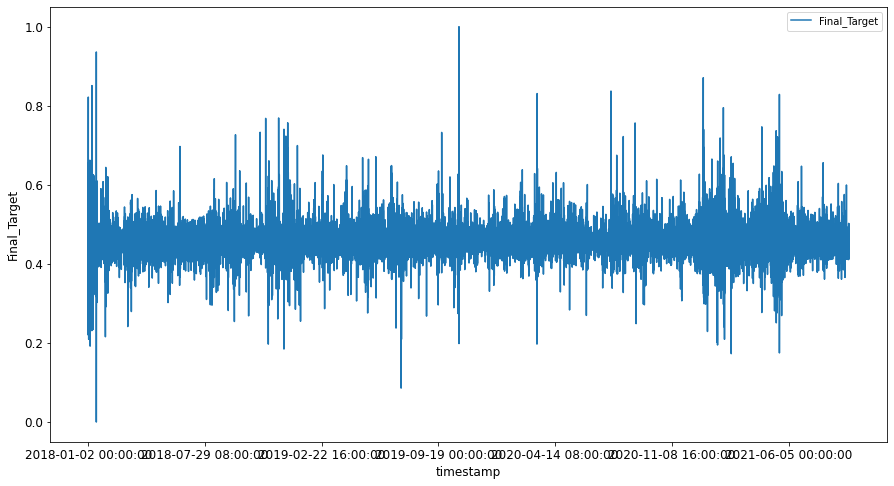

In [3]:
#visualization of the final target 
df.plot(y='Final_Target', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Final_Target', fontsize=12)
plt.show()

In [4]:
# univariate data: Final_target vs Time

uni_data_df = df['Final_Target']
uni_data_df.head()
uni_data_df.shape

(130370,)

In [5]:
uni_data_df.shape

(130370,)

In [6]:
#splitting the data into 70-30
train_start_dt = '2018-01-02'
test_start_dt = '2020-08-11'

## Data visualisation of train and test 

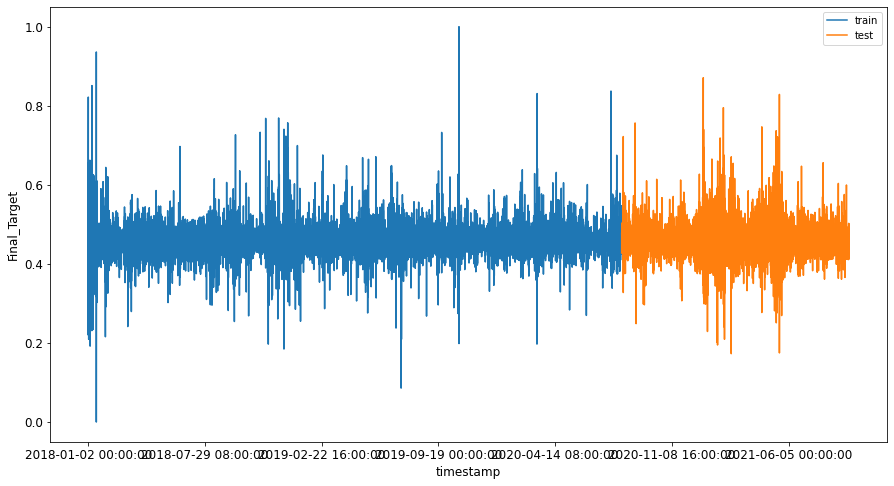

In [7]:
df[(df.index < test_start_dt) & (df.index >= train_start_dt)][['Final_Target']].rename(columns={'Final_Target':'train'}) \
    .join(df[test_start_dt:][['Final_Target']].rename(columns={'Final_Target':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Final_Target', fontsize=12)
plt.show()

In [8]:
train = df.copy()[(df.index >= train_start_dt) & (df.index < test_start_dt)][['Final_Target']]
test = df.copy()[df.index >= test_start_dt][['Final_Target']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (91392, 1)
Test data shape:  (38978, 1)


In [9]:
train.head(10)

,Final_Target
timestamp,
2018-01-02 00:00:00,0.546330
2018-01-02 00:15:00,0.550354
2018-01-02 00:30:00,0.635160
2018-01-02 00:45:00,0.532988
2018-01-02 01:00:00,0.566638
2018-01-02 01:15:00,0.573950
2018-01-02 01:30:00,0.734319
2018-01-02 01:45:00,0.751294
2018-01-02 02:00:00,0.683291


In [10]:
test.shape

(38978, 1)

In [11]:
test.head(10)

,Final_Target
timestamp,
2020-08-11 00:00:00,0.427689
2020-08-11 00:15:00,0.461544
2020-08-11 00:30:00,0.441716
2020-08-11 00:45:00,0.467855
2020-08-11 01:00:00,0.462050
2020-08-11 01:15:00,0.479041
2020-08-11 01:30:00,0.458920
2020-08-11 01:45:00,0.444222
2020-08-11 02:00:00,0.466103


In [12]:
# Converting to numpy arrays
train_data = train.values
test_data = test.values

In [13]:
#using the previous past 4 time steps to predict the next time step i.e 5th min target value
timesteps=5

In [14]:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(91388, 5)

In [15]:
train_data_timesteps

array([[0.54632988, 0.55035361, 0.63515959, 0.53298773, 0.56663839],
       [0.55035361, 0.63515959, 0.53298773, 0.56663839, 0.57395036],
       [0.63515959, 0.53298773, 0.56663839, 0.57395036, 0.73431893],
       ...,
       [0.46315553, 0.45774441, 0.45223693, 0.45438962, 0.44349477],
       [0.45774441, 0.45223693, 0.45438962, 0.44349477, 0.44573861],
       [0.45223693, 0.45438962, 0.44349477, 0.44573861, 0.4606606 ]])

In [16]:
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(38974, 5)

In [17]:
test_data_timesteps

array([[0.42768886, 0.46154377, 0.44171578, 0.46785507, 0.4620502 ],
       [0.46154377, 0.44171578, 0.46785507, 0.4620502 , 0.47904068],
       [0.44171578, 0.46785507, 0.4620502 , 0.47904068, 0.45891978],
       ...,
       [0.41220745, 0.45940606, 0.49019406, 0.45569509, 0.4476771 ],
       [0.45940606, 0.49019406, 0.45569509, 0.4476771 , 0.45339031],
       [0.49019406, 0.45569509, 0.4476771 , 0.45339031, 0.45339031]])

In [18]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(91388, 4) (91388, 1)
(38974, 4) (38974, 1)


In [19]:
x_train,y_train

(array([[0.54632988, 0.55035361, 0.63515959, 0.53298773],
        [0.55035361, 0.63515959, 0.53298773, 0.56663839],
        [0.63515959, 0.53298773, 0.56663839, 0.57395036],
        ...,
        [0.46315553, 0.45774441, 0.45223693, 0.45438962],
        [0.45774441, 0.45223693, 0.45438962, 0.44349477],
        [0.45223693, 0.45438962, 0.44349477, 0.44573861]]),
 array([[0.56663839],
        [0.57395036],
        [0.73431893],
        ...,
        [0.44349477],
        [0.44573861],
        [0.4606606 ]]))

In [20]:
x_test, y_test

(array([[0.42768886, 0.46154377, 0.44171578, 0.46785507],
        [0.46154377, 0.44171578, 0.46785507, 0.4620502 ],
        [0.44171578, 0.46785507, 0.4620502 , 0.47904068],
        ...,
        [0.41220745, 0.45940606, 0.49019406, 0.45569509],
        [0.45940606, 0.49019406, 0.45569509, 0.4476771 ],
        [0.49019406, 0.45569509, 0.4476771 , 0.45339031]]),
 array([[0.4620502 ],
        [0.47904068],
        [0.45891978],
        ...,
        [0.4476771 ],
        [0.45339031],
        [0.45339031]]))

## Model Trainig

In [21]:
model = SVR().fit(x_train, y_train[:,0])
print (model, "\n")

# Evaluate the model using the test data
predictions = model.predict(x_test)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

SVR() 

MSE: 0.0010440412990336484
RMSE: 0.03231162792298847


## Hyperparameter tuning

In [22]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
np.random.seed(0)
param_dist = {'C': [1, 10, 100,1000], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf',"poly"],"epsilon":[0.1,0.2,0.5,0.3]}
tuning_model=RandomizedSearchCV(model,param_dist,scoring='neg_mean_absolute_percentage_error',cv=3,verbose=3,error_score='raise',)

tuning_model.fit(x_train,y_train[:,0])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END C=10, epsilon=0.2, gamma=1, kernel=rbf;, score=-70564902224.736 total time=   0.3s
[CV 2/3] END C=10, epsilon=0.2, gamma=1, kernel=rbf;, score=-0.039 total time=   0.6s
[CV 3/3] END C=10, epsilon=0.2, gamma=1, kernel=rbf;, score=-0.040 total time=   0.8s
[CV 1/3] END C=1, epsilon=0.3, gamma=1, kernel=rbf;, score=-70297793624.303 total time=   0.1s
[CV 2/3] END C=1, epsilon=0.3, gamma=1, kernel=rbf;, score=-0.134 total time=   0.1s
[CV 3/3] END C=1, epsilon=0.3, gamma=1, kernel=rbf;, score=-0.093 total time=   0.1s
[CV 1/3] END C=100, epsilon=0.5, gamma=0.001, kernel=rbf;, score=-80263152515.032 total time=   0.0s
[CV 2/3] END C=100, epsilon=0.5, gamma=0.001, kernel=rbf;, score=-0.098 total time=   0.0s
[CV 3/3] END C=100, epsilon=0.5, gamma=0.001, kernel=rbf;, score=-0.034 total time=   0.0s
[CV 1/3] END C=10, epsilon=0.5, gamma=0.1, kernel=poly;, score=-80263152515.032 total time=   0.0s
[CV 2/3] END C=10, epsil

RandomizedSearchCV(cv=3, error_score='raise', estimator=SVR(),
                   param_distributions={'C': [1, 10, 100, 1000],
                                        'epsilon': [0.1, 0.2, 0.5, 0.3],
                                        'gamma': [1, 0.1, 0.01, 0.001],
                                        'kernel': ['rbf', 'poly']},
                   scoring='neg_mean_absolute_percentage_error', verbose=3)

In [23]:
tuning_model.best_params_

{'kernel': 'poly', 'gamma': 0.001, 'epsilon': 0.1, 'C': 1}

In [24]:
model = SVR(kernel='poly',gamma=0.1, C=1,epsilon= 0.001)

In [25]:
model.fit(x_train, y_train[:,0])

SVR(C=1, epsilon=0.001, gamma=0.1, kernel='poly')

In [26]:
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(91388, 1) (38974, 1)


In [27]:
train_timestamps = df[(df.index < test_start_dt) & (df.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = df[test_start_dt:].index[timesteps-1:]

print(len(train_timestamps), len(test_timestamps))

91388 38974


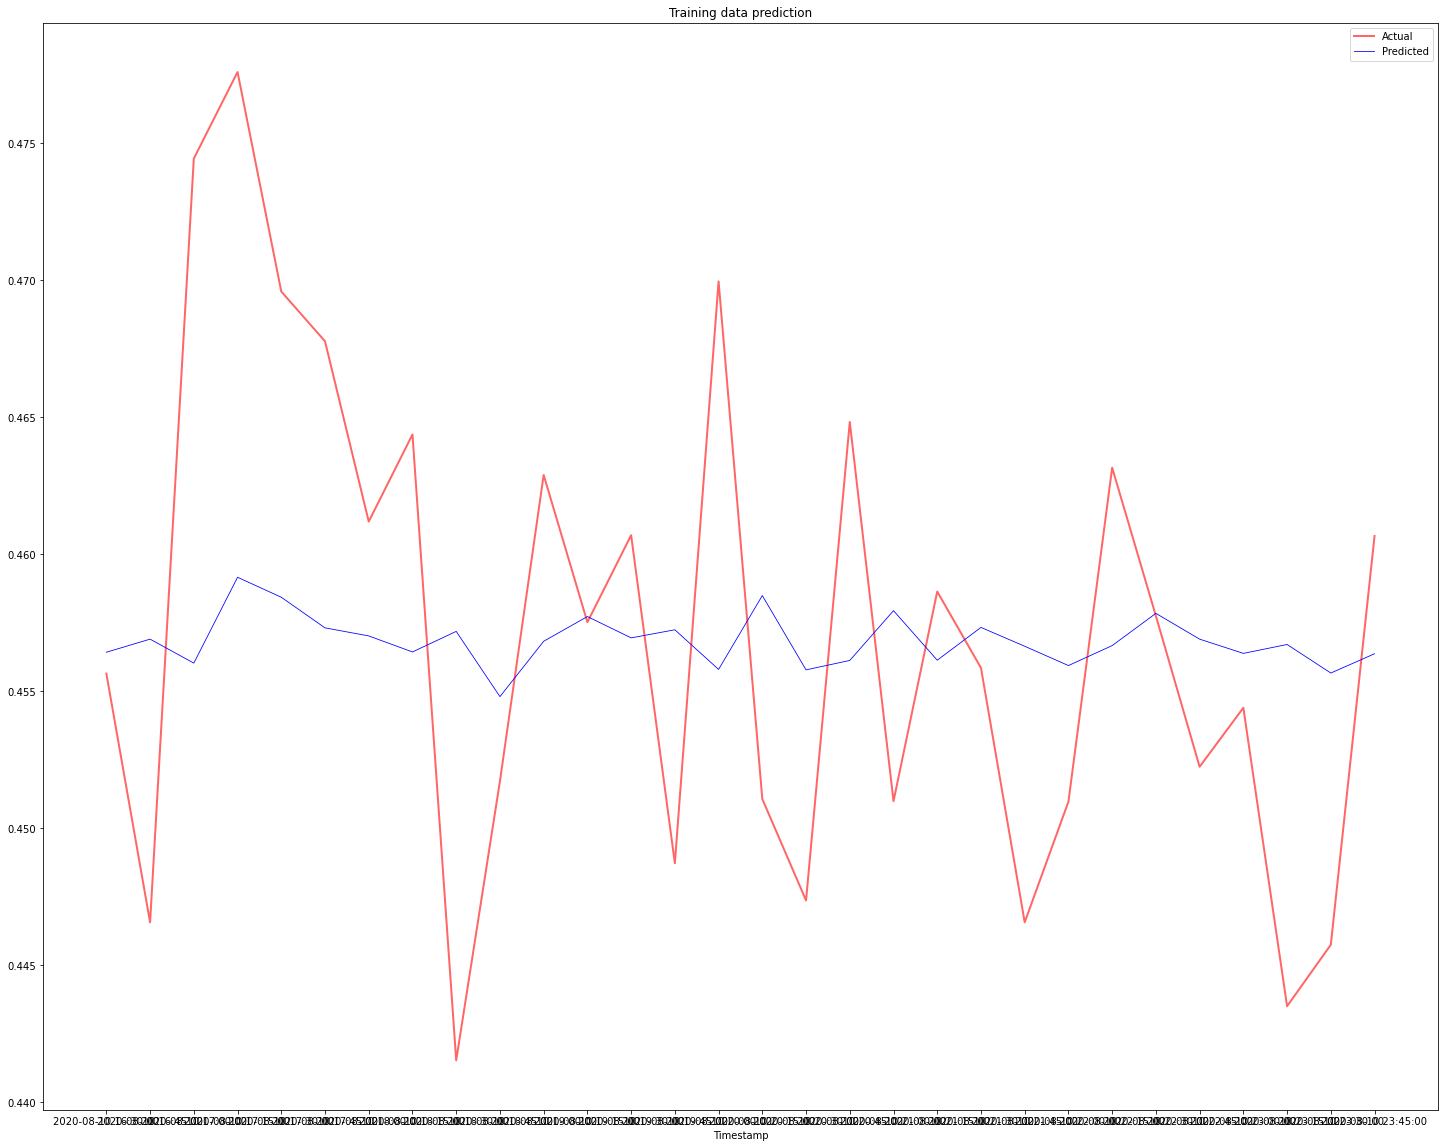

In [28]:
#Visulising the actual vs predicted for the last 30 values in the train data
plt.figure(figsize=(25,20))
plt.plot(train_timestamps[-30:], y_train[-30:], color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps[-30:], y_train_pred[-30:], color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.show()

In [29]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error1(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

In [30]:
#test MAPE
mean_absolute_percentage_error1(y_test,y_test_pred)

3.6545193634748583

In [31]:
#Train MAPE
mean_absolute_percentage_error1(y_train,y_train_pred)

2.961933648253879

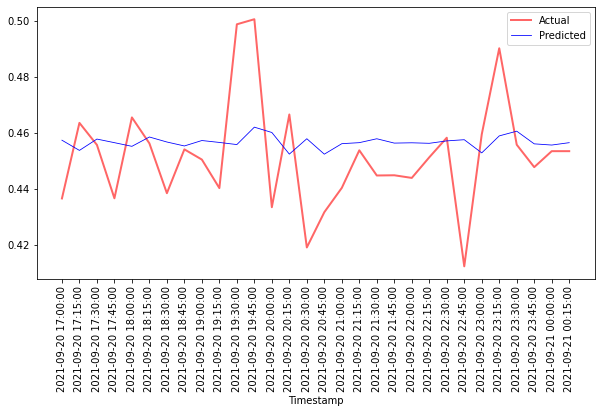

In [32]:
#Visulising the actual vs predicted for the last 30 values in the test data
plt.figure(figsize=(10,5))
plt.plot(test_timestamps[-30:], y_test[-30:], color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps[-30:], y_test_pred[-30:], color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xticks(rotation=90)
plt.xlabel('Timestamp')
plt.show()

In [33]:
mse = mean_squared_error(y_test, y_test_pred)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

MSE: 0.0006617556552018804
RMSE: 0.025724611857166676


In [34]:
mse = mean_squared_error(y_train, y_train_pred)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

MSE: 0.0004530105410275687
RMSE: 0.021284044282691407
